In [35]:
from brian2 import *
import csv
%matplotlib inline

def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(20, 10))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

    
def visualise_plasticity(t, rho, sample=10):
    figure()
    for i in range(min(sample, rho.shape[0])):
        plot(t, rho[i])

In [40]:
start_scope()

#control parameters
debug = True
simulation_length = 2500
observe_window = 10
N = 100

F = 1000*Hz

#Variables used in brian code
cpre_0 = 0.1
cpost_0 = 0.1
rho_0 = 0.6
c = 0.2
dummy = 0.2
Ipre = 0
Ipost = 0
w0 = 0.5


#LIF specific constants
tau_lif = 260*ms
V_init = -60
V_rest = -70
V_reset = -70
V_threshold = -50
CM = 0.001
RM = 20.0
sigma = 5
#sigma = 3.3501
#sigma = 0
refrac = 0


#Synapse model specific constants
rho_init = 0.019
ca_initial = 0
ca_delay = 4.61 #ms
Cpre = 0.56175
Cpost = 1.23964
tau_ca = 22.6936
theta_D = 1
theta_P = 1.3
gamma_D = 331.909
gamma_P = 725.085

taurho = 346361*ms
taurho_fast = 10*ms # dummy
taupre = taupost = tau_ca = 22*ms
rho_star = 0.5
D = 4.6098
#v_ext = 30*mV


lif_eqs = '''
dv/dt = (- v + v_ext) / tau_lif + sigma*xi*tau_lif**-0.5 : 1
v_ext : 1
'''
#P = PoissonGroup(N, rates=F)
# = NeuronGroup(2, eqs, threshold='v>vt', reset='v = vr')
G = NeuronGroup(N, lif_eqs, threshold='v>V_threshold', reset='v = V_rest')
#S = Synapses(G, G, pre='v+=1*mV', connect='i==0 and j==1')
G.v = V_init
#drho = (-rho*(1-rho)*(0.5-rho) ) / taurho : 1
S = Synapses(G, G,
            model = 
            '''
            w : 1 
            dcpre/dt = -cpre / taupre : 1
            dcpost/dt = -cpost / taupost : 1
            c = cpre + cpost : 1
            dummy = (c>theta_D) : 1
            drho/dt = (-rho*(1-rho)*(0.5-rho) + gamma_P*(1-rho)*(c>theta_P) - gamma_D*rho*(c>theta_D)) / taurho : 1
            ''',
            pre =
            '''
            v_post += w
            cpre += Cpre
            
            ''',
            post = 
            '''
            cpost += Cpost
            
            ''')
#S.connect('i==0 and j!=0', p=1.0)
S.connect('i!=j', p=0.1)
#tmp = ((np.arange(len(S))+1) * 4).tolist()
#S.delay = tmp*ms

#S.delay = [4, 40, 400, 4000]*ms
S.w = w0
S.cpre = cpre_0
S.cpost= cpost_0
S.rho = rho_0
G.v_ext = [0] * N
G.v_ext[0] = 1
#statemon = StateMonitor(G, 'v', record = True)
last_5_index = range(simulation_length*10-5, simulation_length*10)
print last_5_index


#spikemon = SpikeMonitor(G)

run((simulation_length-observe_window)*ms, report='stdout', report_period=1*second)
statemon_S = StateMonitor(S, ['rho'], record = True, dt=0.1*ms)
run(observe_window*ms, report='stdout', report_period=1*second)
f = open('rho.csv', 'w')
writer = csv.writer(f)
for row in statemon_S.rho:
    writer.writerow(row)
f.close()
#print statemon_S.rho
#print len(statemon_S)

[24995, 24996, 24997, 24998, 24999]
Starting simulation for duration 2.49 s
1.0663 s (42%) simulated in 1s, estimated 1s remaining.
2.121 s (85%) simulated in 2s, estimated < 1s remaining.
2.49 s (100%) simulated in 2s
Starting simulation for duration 10. ms
10. ms (100%) simulated in < 1s


(1002, 100)
[[ 0.51682976  0.51682976  0.51682976 ...,  0.51519131  0.51519131
   0.51519131]
 [ 0.5133309   0.5133309   0.5133309  ...,  0.51333099  0.51333099
   0.51333099]
 [ 0.52962449  0.5296245   0.5296245  ...,  0.5296247   0.5296247
   0.52962471]
 ..., 
 [ 0.52813557  0.52813557  0.52813557 ...,  0.52813577  0.52813577
   0.52813577]
 [ 0.5188666   0.5188666   0.51886661 ...,  0.51886673  0.51886674
   0.51886674]
 [ 0.50100962  0.50100962  0.50100962 ...,  0.50162734  0.50157927
   0.50153121]]


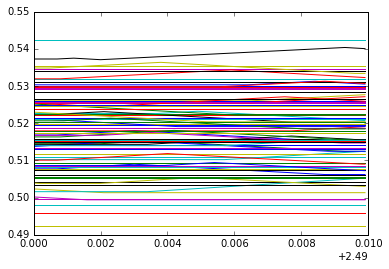

In [39]:
if debug:
    p1 = figure(1, figsize=(20,20))
    visualise_plasticity(statemon_S.t, statemon_S.rho, sample=100)
    print statemon_S.rho.shape
    print statemon_S.rho
#Analysis


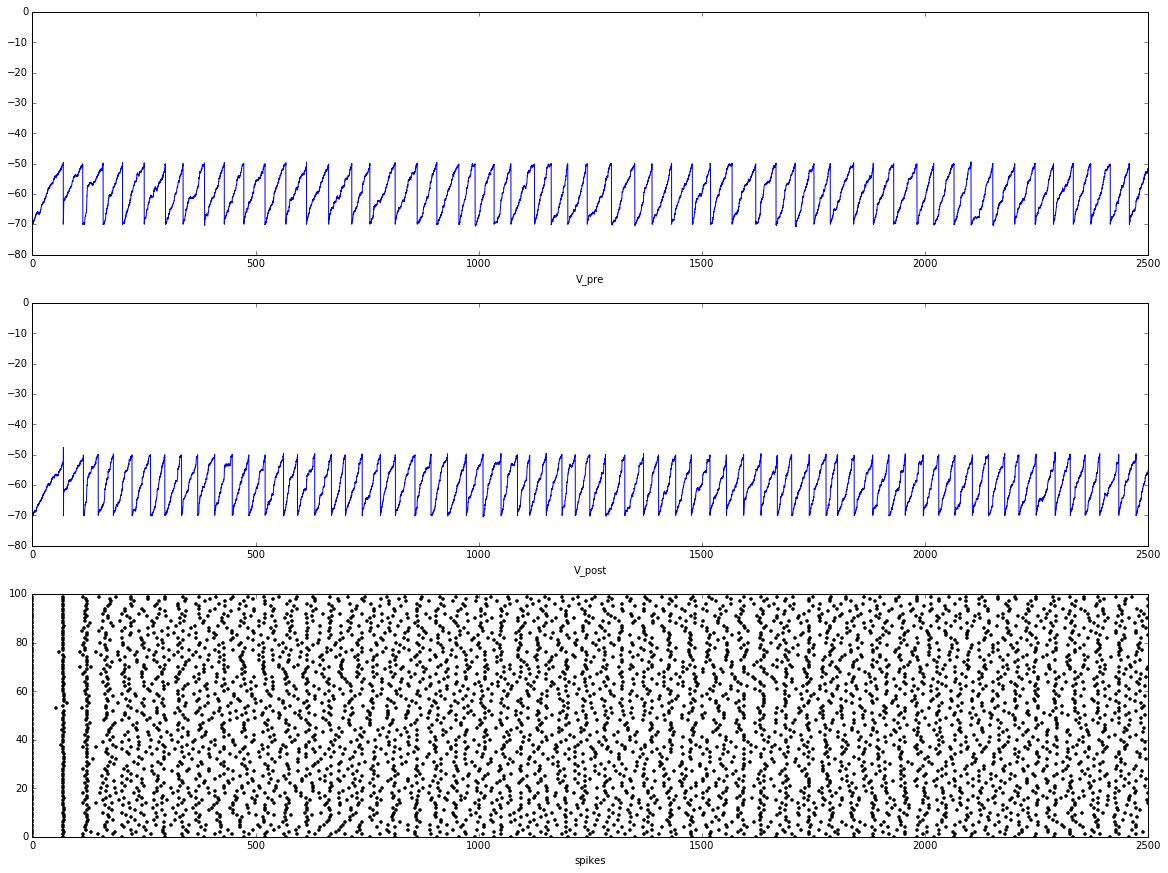

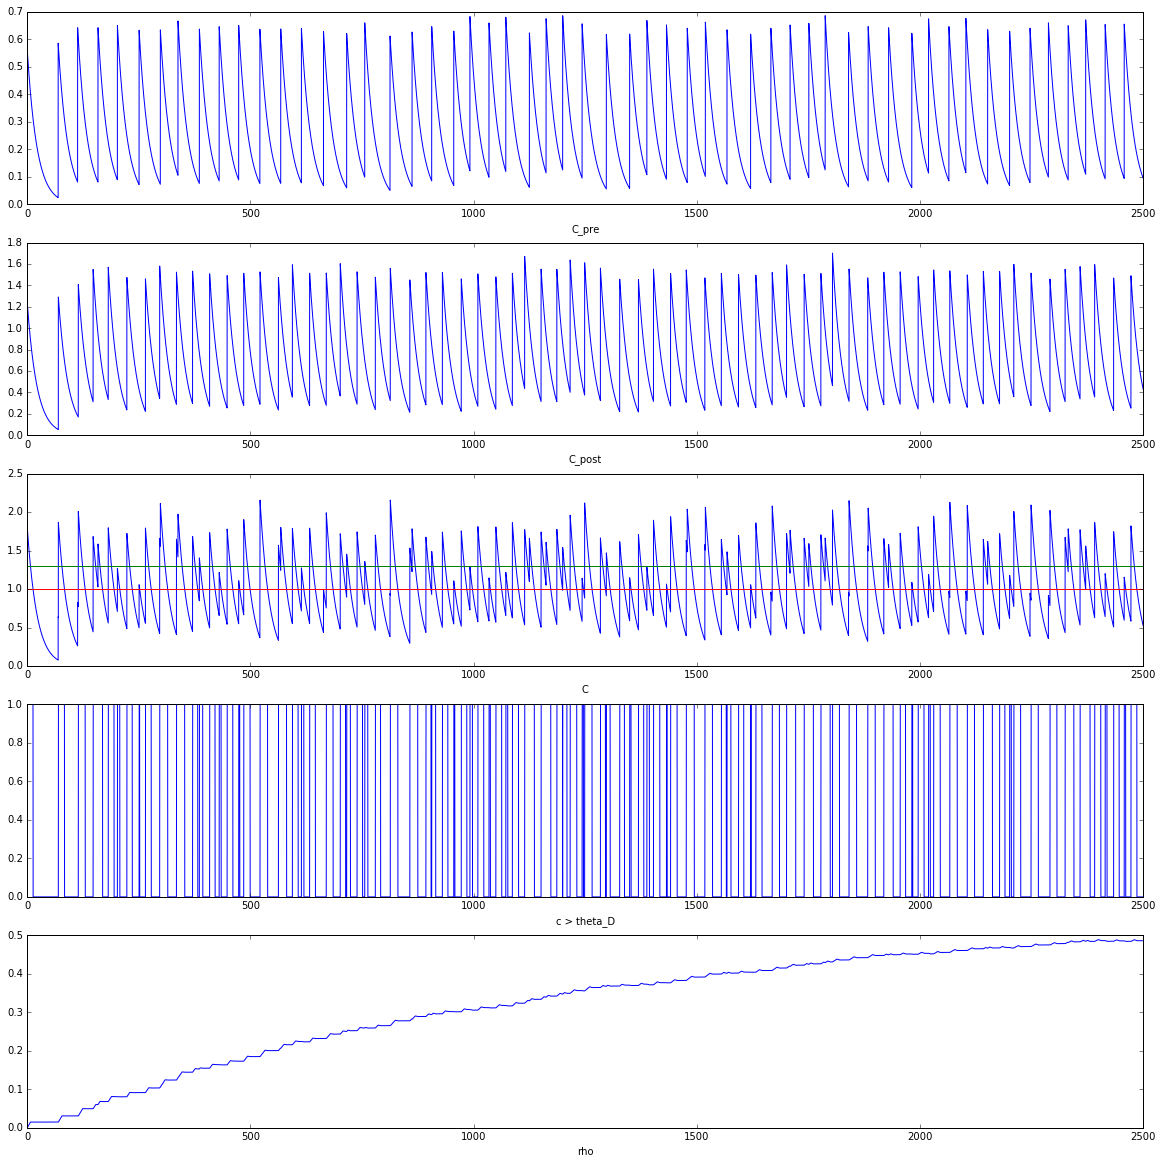

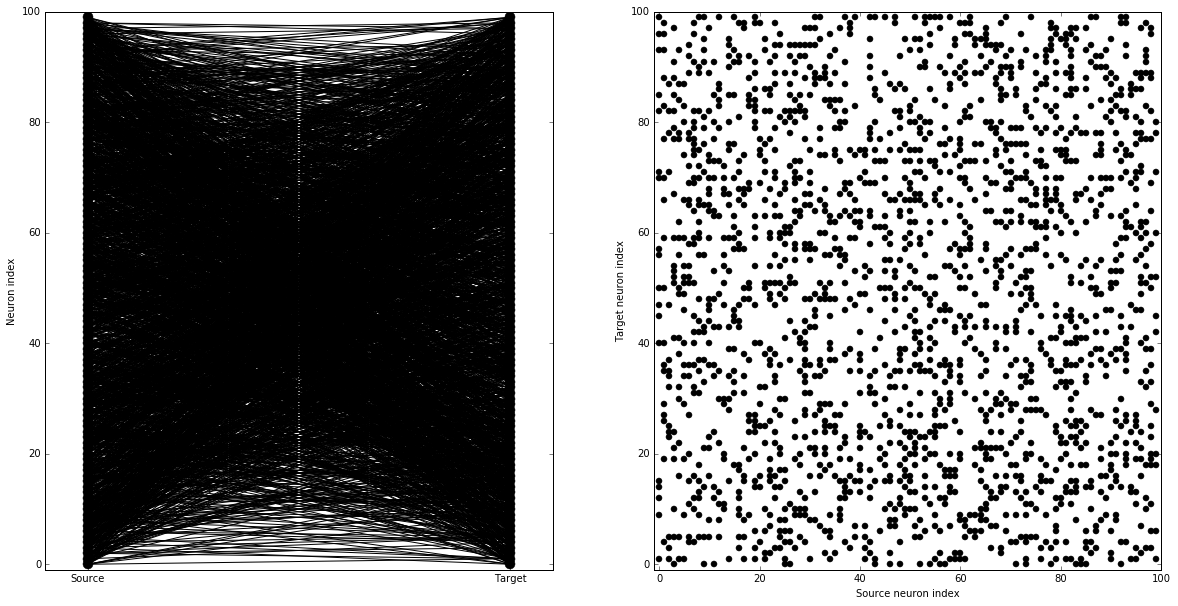

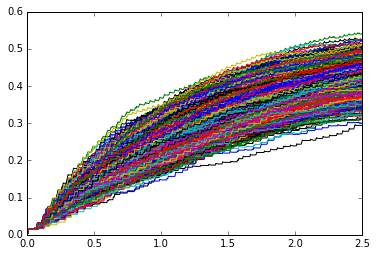

In [5]:
if debug:
    p1 = figure(1, figsize = (20,20))
    subplot(411)
    plot(statemon.t/ms, statemon.v[0])
    xlabel('V_pre')
    subplot(412)
    plot(statemon.t/ms, statemon.v[1])
    xlabel('V_post')
    subplot(413)
    plot(spikemon.t/ms, spikemon.i, '.k')
    xlabel('spikes')
    savefig('a.png')

    p2 = figure(2, figsize = (20,20))
    observe = 0
    subplot(511)
    plot(statemon2.t/ms, statemon2[observe].cpre)
    xlabel('C_pre')
    subplot(512)
    plot(statemon2.t/ms, statemon2[observe].cpost)
    xlabel('C_post')
    subplot(513)
    plot(statemon2.t/ms, statemon2[observe].c)
    plot([0, simulation_length], [theta_P, theta_P])
    plot([0, simulation_length], [theta_D, theta_D])
    xlabel('C')
    subplot(514)
    plot(statemon2.t/ms, statemon2[observe].dummy)
    xlabel('c > theta_D')
    subplot(515)
    plot(statemon2.t/ms, statemon2[observe].rho)
    xlabel('rho')
    savefig('b.png')
    visualise_connectivity(S)
    savefig('c.png')
    
    visualise_plasticity(statemon2.t, statemon2.rho)
    savefig('d.png')